In [33]:
%%writefile ping-pong-2.cpp
/*
2. Then slightly modify the program. Now the processes just send the data with fixed length instead of sending all the previous names. 
Insert timing calls to measure the time taken by all the communications. You will need to time many ping-pong iterations to get a 
reasonable elapsed time, especially for small message lengths.

- Investigate how the time taken varies with the size of the message. 
You should fill in your results in the table from the presentation in Lecture 5 (3 points)

- Plot a graph of time against message size to determine the latency 
(i.e. the time taken for a message of zero length); plot a graph of the 
bandwidth to see how it varies with message size. (3 points)
*/

#include <functional>
#include <memory>
#include <mpi.h>
#include <random>
#include <stdexcept>
#include <vector>
#include <fstream>

//#include <iostream>
//#include <cstdlib>
//#include <ctime>


struct PingPongBall {
public:
  PingPongBall(int data_size ,int num_passes) {
    if (data_size < 0) {
      throw std::runtime_error("the data_size less than 0");
    }
    ball_data.resize(data_size + 2);// Resize the vector to hold the number of passes plus two
    ball_data[0] = num_passes; // Total number of passes
    ball_data[1] = 0;          // current number of passes
  }
  size_t GetSize() const { // Get the size of the vector
    return ball_data.size(); 
    } 
  int &operator[](size_t i) { return ball_data[i]; } // Get the number of passes at index i
  private:
  std::vector<int> ball_data; // Vector to hold the data of the ball
};


int Random_Receiver_Generator(int rank, int size) {
  std::random_device rand_; // unique random number generator
  std::mt19937 engine(rand_()); // sequence engine based on Mersenne Twister algorithm
  std::vector<int> Vec(size, 1); // initialize vector with equal weights
  Vec[rank] = 0; // zero out the current index to prevent selecting it
  std::discrete_distribution<> dist{Vec.begin(), Vec.end()}; // discrete distribution with the given weights
  auto r = std::bind(dist, std::ref(engine)); // function object which generates random numbers based on the distribution
  int selectedReceiverIndex = r(); // invoke the function object to get a random index for the receiver
  return selectedReceiverIndex; 
}

/*

using namespace std;

vector<int> ball(10); // data structure to hold the ball

int main(int argc, char** argv) {
    MPI_Init(&argc, &argv);
    int size, rank;
    MPI_Comm_size(MPI_COMM_WORLD, &size);
    MPI_Comm_rank(MPI_COMM_WORLD, &rank);
    srand(time(nullptr) + rank);

    if (size < 2) {
        cerr << "Error: the number of processes should be at least 2" << endl;
        MPI_Abort(MPI_COMM_WORLD, 1);
    }

    if (rank == 0) {
        // start the game by sending the ball to a random process
        int receiver = rand() % (size - 1) + 1;
        ball[0] = 1; // the number of passes
        ball[1] = 0; // the index of the last player
        ball[2] = rank; // the index of the current player
        cout << "I am " << rank << ", and I am starting the game by sending the ball to " << receiver << endl;
        MPI_Ssend(&ball[0], 10, MPI_INT, receiver, 0, MPI_COMM_WORLD);
    } else {
        while (true) {
            MPI_Recv(&ball[0], 10, MPI_INT, MPI_ANY_SOURCE, MPI_ANY_TAG, MPI_COMM_WORLD, MPI_STATUS_IGNORE);
            if (ball[0] == 1) {
                // the ball has reached its first receiver
                int sender = ball[2];
                int last_player = ball[1];
                cout << "I am " << rank << ", and I have just received the ball from " << sender << endl;
                if (ball[1] == rank) {
                    // the ball has reached the starting process after completing N passes
                    cout << "The game is over!" << endl;
                    ball[0] = -1; // to signal the end of the game
                    MPI_Ssend(&ball[0], 10, MPI_INT, (rank + 1) % size, 0, MPI_COMM_WORLD); // pass the ball to the next player
                    break;
                } else {
                    // continue the game by passing the ball to a random receiver
                    int receiver = rand() % (size - 2);
                    if (receiver >= rank) {
                        receiver++;
                    }
                    ball[1] = rank;
                    ball[2] = last_player;
                    cout << "I am " << rank << ", and I am passing the ball to " << receiver << endl;
                    MPI_Ssend(&ball[0], 10, MPI_INT, receiver, 0, MPI_COMM_WORLD);
                }
            } else if (ball[0] == -1) {
                // the game is over
                MPI_Ssend(&ball[0], 10, MPI_INT, (rank + 1) % size, 0, MPI_COMM_WORLD); // pass the ball to the next player
                break;
            } else {
                // the ball is being passed from one player to another
                int sender = ball[2];
                int last_player = ball[1];
                ball[0]--;
                cout << "I am " << rank << ", and I have just received the ball from " << sender << endl;
                if (ball[0] == 1) {
                    // the ball has reached its last receiver
                    ball[1] = rank;
                    ball[2] = last_player;
                    cout << "I am " << rank << ", and I am passing the ball back to the starting player" << endl;
                } else {
                    // continue the game by passing the ball to a random receiver
                    int receiver = rand() % (size - 2);
                    if (receiver >= rank) {
                        receiver++;
                    }
                    cout << "I am " << rank << ", and I am passing the ball to " << receiver << endl;
                }
                MPI_Ssend(&ball[0], 10, MPI_INT, (rank + 1) % size, 0, MPI_COMM_WORLD); // pass the ball to the next player
            }
        }
    }

    MPI_Finalize();
    return 0;
}

*/

////////////////


struct PassProcess {
public:
  /// Constructor initializes the ball parameter and gets the rank and size of the process.
  /// Throws an error if there are less than 2 processes.
  PassProcess(PingPongBall &ping_pong_ball, bool _iAmGameStarter = false)
      : ball(ping_pong_ball), _iAmGameStarter(_iAmGameStarter) {
    MPI_Comm_rank(MPI_COMM_WORLD, &rank);
    MPI_Comm_size(MPI_COMM_WORLD, &size);

    if (size < 2) {
      throw std::runtime_error("Number of players should be greather than 2");
    }
  }

  /// Main method to start playing the game of pass using MPI send and receive.
  void Play() {
    if (_iAmGameStarter) {
      // If this process is the game starter and enough passes have been made, end the game.
      if (IsSufficientPasses()) {
        return;
      }
      printf("Process 0 start the game \n");
      SetPass();
      MPI_Ssend(&ball[0], ball.GetSize(), MPI_INT, target, 0, MPI_COMM_WORLD);
    }
    while (true) {
      MPI_Probe(MPI_ANY_SOURCE, MPI_ANY_TAG, MPI_COMM_WORLD, &mpistatus);
      MPI_Recv(&ball[0], ball.GetSize(), MPI_INT, mpistatus.MPI_SOURCE, 0, MPI_COMM_WORLD, &mpistatus);

      // If enough passes have been made, end the game.
      if (IsSufficientPasses()) {
        break;
      }
      
      //ball.PrintPassedData();
      printf("Process rank: %d\n", rank);
      SetPass();
      MPI_Ssend(&ball[0], ball.GetSize(), MPI_INT, target, 0, MPI_COMM_WORLD);
    }
  }

private:
  /// Method to check if the game has ended.
  bool IsSufficientPasses() {
    if (ball[0] == -1) {
      return true;
    }
    if (ball[0] == ball[1]) {
      printf("Game Over\n");
      //ball.PrintPassedData();
      printf("Process rank: %d\n", rank);
      ball[0] = -1;
      // Send the final message to end the game.
      for (int i = 0; i < size; ++i) {
        if (i != rank) {
          MPI_Send(&ball[0], ball.GetSize(), MPI_INT, i, 0, MPI_COMM_WORLD);
        }
      }
      return true;
    }
    return false;
  }

  /// Method to prepare the ball for the next pass.
  void SetPass() {
    ball[1]++;
    ball[ball[1] + 1] = rank;
    target = Random_Receiver_Generator(rank, size);
    printf("For pass number: %d , process %d send the ball  to %d\n", ball[1], rank, target);
  }

private:
  int size;
  int rank;
  int target;
  bool _iAmGameStarter{false};
  PingPongBall &ball;
  MPI_Status mpistatus;
};




// Function to initialize the process based on the process rank
auto MakeUniquePlayer(PingPongBall &ping_pong_ball, int rank) {
  if (rank == 0) {
    // If the process rank is zero, the process is the game starter
    return std::unique_ptr<PassProcess>(new PassProcess(ping_pong_ball, true));
  } else {
    // If the process rank is not zero, the process plays as a regular player
    return std::unique_ptr<PassProcess>(new PassProcess(ping_pong_ball));
  }
}
/*
int main(int argc, char **argv) {
  // Total number of passes
  int num_passes = 10;
  // Initialize MPI and get the process rank
  MPI_Init(&argc, &argv);
  int rank;
  MPI_Comm_rank(MPI_COMM_WORLD, &rank);
  // Create a ball object with the given number of passes
  PingPongBall ping_pong_ball(0,num_passes);

  // Initialize the current process and run the game
  auto currentprocess = MakeUniquePlayer(ping_pong_ball, rank);
  currentprocess->Play();

  // Finalize MPI
  MPI_Finalize();
}
*/

int main(int argc, char **argv) {

    MPI_Init(&argc, &argv);

    int rank;
    MPI_Comm_rank(MPI_COMM_WORLD, &rank);

    // Customize here
    int ballSize = 16384; //8192; //4096; //2048; //1024; //512;
    int warmupIterations = 0;
    int mainIterations = 1;  
    int num_passes = 10;

    std::ofstream file("statistics.txt", std::ios_base::app);

    PingPongBall ping_pong_ball(ballSize, num_passes);

    auto player = MakeUniquePlayer(ping_pong_ball,rank);

    // Warm up players before the game
    for (size_t i = 0; i < warmupIterations; i++)
    {
        player->Play();
    }

    double start = MPI_Wtime();
    // Main loop to be monitored
    for (size_t i = 0; i < mainIterations; i++)
    {

        player->Play();
    }
    double end = MPI_Wtime();

    auto elapsedTime = end-start;
    // each iteration has 2 transfers: send and receive
    auto transferTime = elapsedTime/(mainIterations * num_passes);
    auto ballSizeInGigaByte = ballSize * 4.0 /* byte */ / 1000000000.0;

    if (rank==0) 
    {
        file <<"Total time (Sec): " << elapsedTime << ";";
        file << "Ball size (GB): "<< ballSizeInGigaByte<<";";
        file << "Transfer time (Sec): "<< transferTime <<";";
        file << "Bandwidth (GB/s): " << ballSizeInGigaByte/transferTime <<std::endl;
    }
    
    MPI_Finalize();
}








Overwriting ping-pong-2.cpp


In [34]:
!mpic++  ping-pong-2.cpp -lstdc++ -o test

In [35]:
!mpirun -n 5 --allow-run-as-root --oversubscribe ./test

Process 0 start the game 
For pass number: 1 , process 0 send the ball  to 3
Process rank: 3
For pass number: 2 , process 3 send the ball  to 1
Process rank: 1
For pass number: 3 , process 1 send the ball  to 0
Process rank: 0
For pass number: 4 , process 0 send the ball  to 1
Process rank: 1
For pass number: 5 , process 1 send the ball  to 3
Process rank: 3
For pass number: 6 , process 3 send the ball  to 4
Process rank: 4
For pass number: 7 , process 4 send the ball  to 2
Process rank: 2
For pass number: 8 , process 2 send the ball  to 3
Process rank: 3
For pass number: 9 , process 3 send the ball  to 2
Process rank: 2
For pass number: 10 , process 2 send the ball  to 4
Game Over
Process rank: 4


- Investigate how the time taken varies with the size of the message. You should fill in your results in the table from the presentation in Lecture 5 (3 points)



In [36]:
# Result for 10 passes with 5 processes
! cat statistics.txt 

Total time (Sec): 0.00146839;Ball size (GB): 2.048e-06;Transfer time (Sec): 0.000146839;Bandwidth (GB/s): 0.0139473
Total time (Sec): 0.00275335;Ball size (GB): 4.096e-06;Transfer time (Sec): 0.000275335;Bandwidth (GB/s): 0.0148764
Total time (Sec): 0.00213279;Ball size (GB): 8.192e-06;Transfer time (Sec): 0.000213279;Bandwidth (GB/s): 0.0384098
Total time (Sec): 0.0190886;Ball size (GB): 1.6384e-05;Transfer time (Sec): 0.00190886;Bandwidth (GB/s): 0.00858312
Total time (Sec): 0.00224368;Ball size (GB): 3.2768e-05;Transfer time (Sec): 0.000224368;Bandwidth (GB/s): 0.146046
Total time (Sec): 0.00421109;Ball size (GB): 6.5536e-05;Transfer time (Sec): 0.000421109;Bandwidth (GB/s): 0.155627


In [45]:
import pandas as pd
import matplotlib.pyplot as plt

In [42]:



data = {'Total time (Sec)': [0.00146839, 0.00275335, 0.00213279,0.0190886,0.00224368,0.00421109 ], 'Ball size (GB)': [2.048e-06, 4.096e-06, 8.192e-06, 1.6384e-05, 3.2768e-05,6.5536e-05 ],
        'Transfer time (Sec)': [0.000146839, 0.000275335, 0.000213279, 0.00190886,0.000224368 , 0.000421109], 'Bandwidth (GB/s)': [0.0139473,0.0148764, 0.0384098, 0.00858312, 0.146046,  0.155627] }

df = pd.DataFrame.from_dict(data)
df

,Total time (Sec),Ball size (GB),Transfer time (Sec),Bandwidth (GB/s)
0,0.001468,0.000002,0.000147,0.013947
1,0.002753,0.000004,0.000275,0.014876
2,0.002133,0.000008,0.000213,0.038410
3,0.019089,0.000016,0.001909,0.008583
4,0.002244,0.000033,0.000224,0.146046
5,0.004211,0.000066,0.000421,0.155627


- Plot a graph of time against message size to determine the latency (i.e. the time taken for a message of zero length); plot a graph of the bandwidth to see how it varies with message size. (3 points)

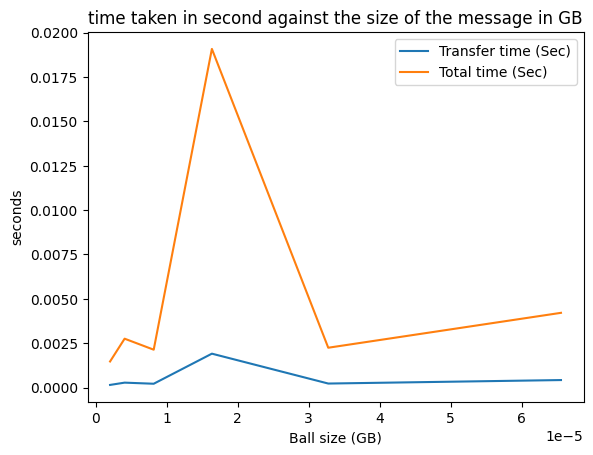

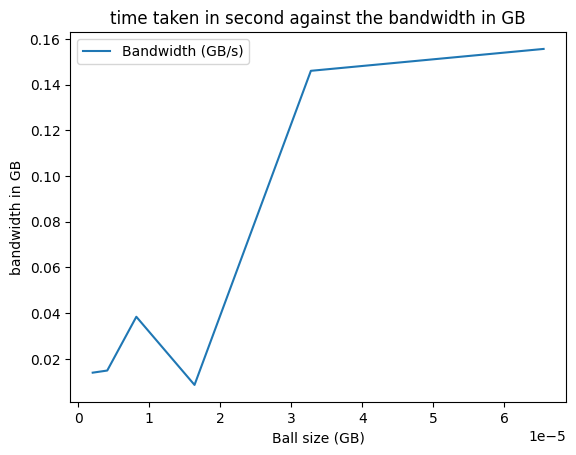

In [50]:
df.plot.line(x='Ball size (GB)', y=['Transfer time (Sec)', 'Total time (Sec)' ])
plt.title("time taken in second against the size of the message in GB")
plt.ylabel("seconds")
plt.show()

df.plot.line(x='Ball size (GB)', y="Bandwidth (GB/s)")
plt.title("time taken in second against the bandwidth in GB")
plt.ylabel("bandwidth in GB")
plt.show()